### Import all the necessary modules, packages, and libraries to complete this assignment.

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':'tight'}
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from time import time
from math import sqrt
from sklearn import linear_model, model_selection
from sklearn.preprocessing import minmax_scale as scale
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import tensorflow as tf

### Increase the size of the output window to 1000px

In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

### Color map for plot lines

In [3]:
chart_colors = ['#3366CC', # 0.  light blue
                '#DC3912', # 1.  orange
                '#FF9900', # 2.  yellow
                '#109618', # 3.  bright green
                '#990099', # 4.  bright purple
                '#3B3EAC', # 5.  mid blue
                '#0099C6', # 6.  turquoise
                '#DD4477', # 7.  pink
                '#66AA00', # 8.  pastel green
                '#B82E2E', # 9.  maroon
                '#316395', # 10. dark turquoise
                '#994499', # 11. pastel purple
                '#22AA99', # 12. aqua
                '#AAAA11', # 13. greenish yellow
                '#6633CC', # 14. dark purple
                '#E67300', # 15. dark yellow
                '#8B0707', # 16. dark maroon / brown
                '#329262', # 17. greenish blue
                'violet',  # 18.
                '#5574A6', # 19. muted blue
                'orange',  # 20.
                'gray',    # 21.
                'green',   # 22.
                '#3B3EAC', # 23. muted purple
                'red',     # 24. 
                '#5050A0', # 25. another muted dark blue
                'yellow',  # 26.
                '#9aeabb', # 27. green
                '#eec27f', # 28. orange
                '#90afe5', # 29. blue
                '#f6afaf', # 30. pink
                '#fbf8b6', # 31. yellow
                ]

# 1 (30pts) Polynomial regression / overfitting / regularization

### Read in first dataset

In [4]:
data = pd.read_csv('ex2data1.csv')

## 1-1 Fit the data using linear (1st order) regression model (matrix form, gradient descent method). Plot the data with the fitted line. Print optimized weights. Print Root Mean Squared Error (RMSE).

### Initialize learning rates, data,  labels, and weights; define cost, cost derivative, and weight updating functions

In [5]:
learning_rates = [0.1, 0.01, 1e-3, 1e-4]

X = np.stack([
        np.ones((len(data))),
        data.iloc[:, 0]],
        axis=1)
y = np.asmatrix(data.iloc[:, -1]).reshape(len(data), -1)

W_init = np.asmatrix(np.array([0., 0.]).reshape(2, -1))
W = np.copy(W_init)

J = lambda X, y: (1/len(data)) * np.dot((np.dot(X, W) - y).T, np.dot(X, W) - y)
dJ_dW = lambda X, y: (2/len(data)) * (np.dot(np.dot(X.T, X), W) - np.dot(X.T, y))

def update_weights(W, alpha):
    W -= alpha*dJ_dW(X, y)
    return W

### Define data and model plot functions

In [6]:
def data_plotter(title):
    formatting = {'fontsize': 15, 'weight': 'bold'}
    plt.title(title, formatting)
    plt.xlabel('X', formatting)
    plt.ylabel('Y', formatting, rotation=0)
    plt.xlim(min(data.iloc[:, 0]) - (2 * min(data.iloc[:, 0])), 
             max(data.iloc[:, 0]) + (.1 * max(data.iloc[:, 0])))
    plt.ylim(min(data.iloc[:, -1]) - (2 * min(data.iloc[:, 0])), 
             max(data.iloc[:, -1]) + (.2 * max(data.iloc[:, 0])))
    plt.grid(True)
    plt.scatter(data.iloc[:, 0], data.iloc[:, -1])

def model_plotter(model):
    Y_hat = np.array(list(map(model, X[:, 1])))
    pairs = sorted(zip(data.iloc[:, 0], Y_hat))
    plt.plot([p[0] for p in pairs], [p[1] for p in pairs]) 

### Define learning function

In [7]:
def train_model(X, y, learning_rates, suppress_results=False, test_split=None):
    global W, W_init
    
    if not suppress_results:
        if test_split:
            rmse = (sqrt(float(J(X, y))), sqrt(float(J(test_split[0], test_split[1]))))
            print('\nTraining RMSE: {}\nTesting RMSE: {}'.format(rmse[0], rmse[1]))
        else:
            print('\nInitial RMSE: {}'.format(sqrt(float(J(X, y)))))

    results = []
    for alpha in learning_rates:
        if not suppress_results:
            print('Performing gradient descent with a learning rate of {}'.format(alpha))
    
        W = np.copy(W_init)
                              
        new_cost, old_cost, start, count = float(J(X, y)), float('inf'), time(), 0
        beginning = start
        
        while new_cost < old_cost and abs(old_cost - new_cost) > 1e-5:
            old_cost = float(new_cost)
            W = update_weights(W, alpha)
            
            new_cost = float(J(X, y))
                
            if time() - start > 10:
                print('\tCost: {}'.format(new_cost))
                start = time()
            count += 1
        end = time()
        
        if test_split:
            rmse = (sqrt(float(J(X, y))), sqrt(float(J(test_split[0], test_split[1]))))
            print('\nTraining RMSE: {}\nTesting RMSE: {}\nachieved after {time:.2f} seconds and {count} iterations\n'.format( 
                    rmse[0],
                    rmse[1],
                    time=end-beginning,
                    count=count))
        else:
            rmse = sqrt(float(J(X, y)))
            print('\tFinal RMSE: {} achieved after {time:.2f} seconds and {count} iterations\n'.format( 
                    rmse, 
                    time=end-beginning,
                    count=count))
              
        results.append([rmse, alpha, W])
    
    if not suppress_results:
        if test_split:
            best = min(results, key=lambda x: x[0][1])
        else:
            best = min(results, key=lambda x: x[0])
        print('The best model has:\n\tRMSE = {}\n\tlearning rate = {}\n\tW = {}'.format(best[0], best[1], '\n\t    '.join([str(float(r)) for r in best[2]]))) 
    return results

### Perform matrix form gradient descent on the first dataset to fit a 1st order linear model

In [8]:
results = train_model(X, y, learning_rates)


Initial RMSE: 0.7335894087051757
Performing gradient descent with a learning rate of 0.1
	Final RMSE: 0.4766740219858785 achieved after 0.01 seconds and 249 iterations

Performing gradient descent with a learning rate of 0.01
	Final RMSE: 0.48070713662629017 achieved after 0.03 seconds and 1502 iterations

Performing gradient descent with a learning rate of 0.001
	Final RMSE: 0.5193038157458554 achieved after 0.10 seconds and 5142 iterations

Performing gradient descent with a learning rate of 0.0001
	Final RMSE: 0.6061032858949542 achieved after 0.11 seconds and 4875 iterations

The best model has:
	RMSE = 0.4766740219858785
	learning rate = 0.1
	W = 1.0348563527735277
	    -1.1151457964875555


### Plot first dataset with the 1st order linear model fit to it

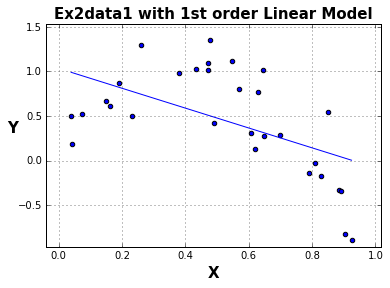

In [9]:
data_plotter('Ex2data1 with 1st order Linear Model')
W0, W1 = [float(w) for w in min(results)[-1]]
model = lambda x: W0 + W1*x
model_plotter(model)

## 1-2 Fit the data using 2nd order polynomial regression model (matrix form, gradient descent method). Plot the data with the fitted line. Print optimized weights. Print Root Mean Squared Error (RMSE). Note: Do not forget feature normalization.

### Initialize data, labels, and weights

In [10]:
X = np.stack([
        np.ones((len(data))),
        scale(data.iloc[:, 0]),
        scale(list(map(lambda x: x**2, data.iloc[:, 0])))],
        axis=1)
y = np.asmatrix(data.iloc[:, -1]).reshape(len(data), -1)

W_init = np.asmatrix(np.array([0., 0., 0.]).reshape(-1, 1))
W = np.copy(W_init)

### Perform matrix form gradient descent on the first dataset to fit a 2nd order polynomial model

In [11]:
results = train_model(X, y, learning_rates)


Initial RMSE: 0.7335894087051757
Performing gradient descent with a learning rate of 0.1
	Final RMSE: 0.2990640544013716 achieved after 0.06 seconds and 2052 iterations

Performing gradient descent with a learning rate of 0.01
	Final RMSE: 0.3998790687268308 achieved after 0.06 seconds and 2482 iterations

Performing gradient descent with a learning rate of 0.001
	Final RMSE: 0.4463382369183588 achieved after 0.10 seconds and 4928 iterations

Performing gradient descent with a learning rate of 0.0001
	Final RMSE: 0.5899631357770813 achieved after 0.14 seconds and 6317 iterations

The best model has:
	RMSE = 0.2990640544013716
	learning rate = 0.1
	W = 0.5316078954639762
	    2.543096217706851
	    -3.6008283578344193


### Plot first dataset with the 2nd order polynomial regression model fit to it

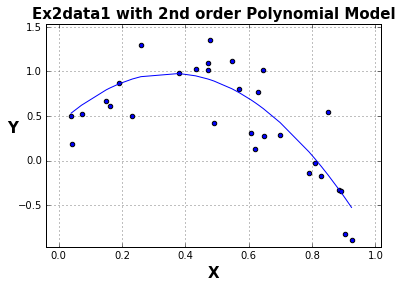

In [12]:
data_plotter('Ex2data1 with 2nd order Polynomial Model')
W0, W1, W2 = [float(w) for w in min(results)[-1]]
model = lambda x: W0 + W1*x + W2*x**2
model_plotter(model)

## 1-3 Fit the data using 4th order polynomial regression model (matrix form, gradient descent method). Plot the data with the fitted line. Print optimized weights. Print Root Mean Squared Error (RMSE). Note: Do not forget feature normalization.

### Initialize data, labels, and weights

In [13]:
X = np.stack([
        np.ones((len(data))),
        scale(data.iloc[:, 0]),
        scale(list(map(lambda x: x**2, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**3, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**4, data.iloc[:, 0])))],
        axis=1)
y = np.asmatrix(data.iloc[:, -1]).reshape(len(data), -1)

W_init = np.asmatrix(np.array([0., 0., 0., 0., 0.]).reshape(-1, 1))
W = np.copy(W_init)

### Perform matrix form gradient descent on the first dataset to fit a 4th order polynomial model

In [14]:
results = train_model(X, y, learning_rates)


Initial RMSE: 0.7335894087051757
Performing gradient descent with a learning rate of 0.1
	Final RMSE: 0.3005477019509741 achieved after 0.01 seconds and 604 iterations

Performing gradient descent with a learning rate of 0.01
	Final RMSE: 0.32609134554076274 achieved after 0.05 seconds and 1899 iterations

Performing gradient descent with a learning rate of 0.001
	Final RMSE: 0.37214286194226615 achieved after 0.09 seconds and 3964 iterations

Performing gradient descent with a learning rate of 0.0001
	Final RMSE: 0.4938540516332719 achieved after 0.28 seconds and 11722 iterations

The best model has:
	RMSE = 0.3005477019509741
	learning rate = 0.1
	W = 0.582929944000473
	    1.0759496505993527
	    -0.2226365235732516
	    -0.9024418036797143
	    -1.2279976702406672


### Plot first dataset with the 4th order polynomial model fit to it

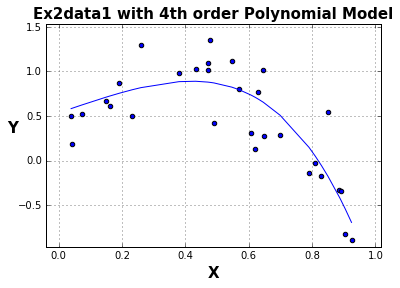

In [15]:
data_plotter('Ex2data1 with 4th order Polynomial Model')
W0, W1, W2, W3, W4 = [float(w) for w in min(results)[-1]]
model = lambda x: W0 + W1*x + W2*x**2 + W3*x**3 + W4*x**4
model_plotter(model)

## 1-4 Fit the data using 16th order polynomial regression model (matrix form, gradient descent method). Plot the data with the fitted line. Print optimized weights. Print Root Mean Squared Error (RMSE). Note: Do not forget feature normalization.

### Initialize data, labels, and weights

In [16]:
X = np.stack([
        np.ones(len(data)),
        scale(data.iloc[:, 0]),
        scale(list(map(lambda x: x**2, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**3, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**4, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**5, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**6, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**7, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**8, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**9, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**10, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**11, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**12, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**13, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**14, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**15, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**16, data.iloc[:, 0])))],
        axis=1)
y = np.asmatrix(data.iloc[:, -1]).reshape(len(data), -1)

W_init = np.asmatrix(np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]).reshape(-1, 1))
W = np.copy(W_init)

### Perform matrix form gradient descent on the first dataset to fit a 16th order polynomial model

In [17]:
results = train_model(X, y, learning_rates)


Initial RMSE: 0.7335894087051757
Performing gradient descent with a learning rate of 0.1
	Final RMSE: 0.3086079143912908 achieved after 0.02 seconds and 651 iterations

Performing gradient descent with a learning rate of 0.01
	Final RMSE: 0.33112371167648186 achieved after 0.01 seconds and 362 iterations

Performing gradient descent with a learning rate of 0.001
	Final RMSE: 0.33888556766994343 achieved after 0.05 seconds and 2043 iterations

Performing gradient descent with a learning rate of 0.0001
	Final RMSE: 0.3943106601049357 achieved after 0.28 seconds and 9905 iterations

The best model has:
	RMSE = 0.3086079143912908
	learning rate = 0.1
	W = 0.613943838861208
	    0.7441499391915972
	    -0.18117241631995182
	    -0.46843320017963214
	    -0.4722378591495171
	    -0.3818489274944494
	    -0.2751600307992868
	    -0.1808922151646224
	    -0.10729145199029261
	    -0.05446227407685552
	    -0.019640775979192355
	    0.0005980015067956635
	    0.009476086981460225
	    0.009731

### Plot first dataset with the 16th order polynomial model fit to it

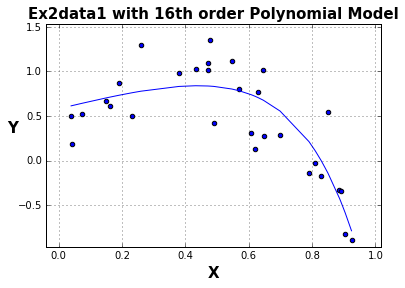

In [18]:
data_plotter('Ex2data1 with 16th order Polynomial Model')
W0, W1, W2, W3, W4, W5, W6, W7, W8, W9, W10, W11, W12, W13, W14, W15, W16 = [float(w) for w in min(results)[-1]]
model = lambda x: W0 + W1*x + W2*x**2 + W3*x**3 + W4*x**4 + W5*x**5 + W6*x**6 + W7*x**7 + W8*x**8 + W9*x**9 \
                + W10*x**10 + W11*x**11 + W12*x**12 + W13*x**13 + W14*x**14 + W15*x**15 + W16*x**16
model_plotter(model)

## 1-5 Fit the data using 16th order polynomial regression model with ridge (L2 penalty) regularization (matrix form, gradient descent method). You need to try at least 3 different L2 penalty (for example, λ = 0.1, 1, 10). Plot the data with the fitted line. Print optimized weights. Print Root Mean Squared Error (RMSE). Note: Do not forget feature normalization.

### Define $W/\lambda$ plotting function

In [19]:
def regularization_plotter(title, results):
    formatting = {'fontsize': 15, 'weight': 'bold'}
    plt.title(title, formatting)
    plt.xlabel(r'$\lambda$', formatting)
    plt.ylabel('coefficients', formatting)
    plt.xlim(min([r[3] for r in results]) - abs(2 * min([r[3] for r in results])), 
             max([r[3] for r in results]) + (.1 * max([r[3] for r in results])))
    plt.ylim(min([float(w) for r in results for w in r[2]]) - abs(.02 * min([float(w) for r in results for w in r[2]])), 
             max([float(w) for r in results for w in r[2]]) + (.2 * max([float(w) for r in results for w in r[2]])))
    plt.grid(True)
    for f, _feature in enumerate(X.T):
        feature_weights = [float(results[l][2][f]) for l, _lambda in enumerate(lambdas)]
        x, y = zip(*sorted(zip(lambdas, feature_weights)))
        plt.plot(x, y, color=chart_colors[f])

### Create 60/20/20 training, validation, testing split on the data and labels

In [20]:
X_, X_test, y_, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_, y_, test_size=0.25, random_state=42)

### Redefine cost and cost derivative functions to include the L2 regularization term; initialize lambda values

In [21]:
J = lambda X, y: (1/len(data)) * (np.dot((np.dot(X, W) - y).T, np.dot(X, W) - y) \
        + np.multiply(l, np.dot(W.T, W)))
dJ_dW = lambda X, y: (2/len(data)) * (np.dot(np.dot(X.T, X), W) - np.dot(X.T, y) \
        + np.multiply(l, np.dot(np.eye(W.shape[0]), W)))
lambdas = [0.1, 1, 5, 10, 50, 100, 200]

### Tune model on validation set to find optimal lambda for L2 regularization

In [22]:
learning_rate = min(results)[1]
results = []
for l in lambdas:
    print('Performing gradient descent with an L2 regularization parameter of {}'.format(l))
    W = np.copy(W_init)
    results.append(train_model(X_val, y_val, [learning_rate], suppress_results=True, test_split=(X_test, y_test))[0] + [l])

Performing gradient descent with an L2 regularization parameter of 0.1

Training RMSE: 0.18100438457803408
Testing RMSE: 0.166379350481566
achieved after 0.00 seconds and 46 iterations

Performing gradient descent with an L2 regularization parameter of 1

Training RMSE: 0.22653316580754002
Testing RMSE: 0.21965133396840592
achieved after 0.00 seconds and 17 iterations

Performing gradient descent with an L2 regularization parameter of 5

Training RMSE: 0.30186308418246605
Testing RMSE: 0.2919474822741178
achieved after 0.00 seconds and 7 iterations

Performing gradient descent with an L2 regularization parameter of 10

Training RMSE: 0.3314766548903406
Testing RMSE: 0.31497974463972644
achieved after 0.00 seconds and 4 iterations

Performing gradient descent with an L2 regularization parameter of 50

Training RMSE: 0.38316515387513195
Testing RMSE: 0.3645704073791526
achieved after 0.00 seconds and 2 iterations

Performing gradient descent with an L2 regularization parameter of 100

Tr

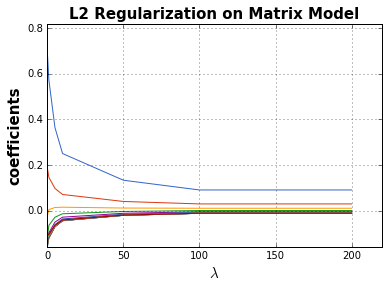

In [23]:
regularization_plotter('L2 Regularization on Matrix Model', results)
#lambdas = [0.1, 1, 5, 10, 50, 100, 200]

### Plot first dataset with the 16th order polynomial L2 regularized model fit to it

The best model has:
	RMSE = (0.3314766548903406, 0.31497974463972644)
	learning rate = 0.1
	lambda: 10
	W = 0.25016198733795414
	    0.07070535460317914
	    0.014897449107538496
	    -0.013898046554835482
	    -0.02877085865374113
	    -0.03666011937973922
	    -0.04084903254823122
	    -0.04299162125306504
	    -0.04397051632416961
	    -0.04427596069144167
	    -0.04418830349136253
	    -0.043871519359522076
	    -0.043423232522425775
	    -0.0429023479906337
	    -0.04234472164491749
	    -0.04177225390317919
	    -0.04119827685392058


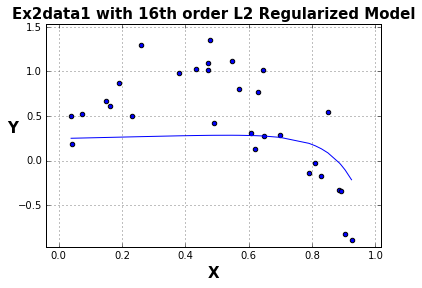

In [24]:
best = results[3]
print('The best model has:\n\tRMSE = {}\n\tlearning rate = {}\n\tlambda: {}\n\tW = {}'.format(best[0], best[1], best[3], '\n\t    '.join([str(float(r)) for r in best[2]]))) 

data_plotter('Ex2data1 with 16th order L2 Regularized Model')
W0, W1, W2, W3, W4, W5, W6, W7, W8, W9, W10, W11, W12, W13, W14, W15, W16 = [float(w) for w in best[2]]
model = lambda x: W0 + W1*x + W2*x**2 + W3*x**3 + W4*x**4 + W5*x**5 + W6*x**6 + W7*x**7 + W8*x**8 + W9*x**9 \
                + W10*x**10 + W11*x**11 + W12*x**12 + W13*x**13 + W14*x**14 + W15*x**15 + W16*x**16
model_plotter(model)

## 1-6 Fit the data using 16th order polynomial regression model with scikit-learn Ridge model. You need to try at least 3 different L2 penalty (for example, λ = 0.1, 1, 10). Plot the data with the fitted line. Print optimized weights. Print Root Mean Squared Error (RMSE).

### Fit the first dataset to a 16th order polynomial L2 regularized model using scikit-learn 

In [25]:
results = []
lambdas = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
for l in lambdas:
    model = linear_model.Ridge(alpha=l)
    
    model.fit(X_train, y_train)
    y_hat = model.predict(X_train)
    rmse_train = sqrt(np.mean(np.square(y_hat - y_train)))
    
    y_hat = model.predict(X_test)
    rmse_test = sqrt(np.mean(np.square(y_hat - y_test)))
    results.append(((rmse_train, rmse_test), model.intercept_[0], [str(c) for c in model.coef_[0]], l, model))

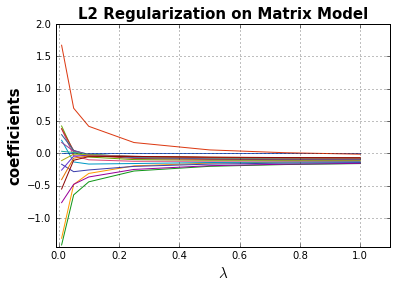

In [26]:
regularization_plotter('L2 Regularization on Matrix Model', results)

### Plot first dataset with the 16th order polynomial L2 regularized model (sklearn Ridge) fit to it

RMSE: (0.28141744538395647, 0.3796981940817162)
Lambda: 0.25
Intercept: 0.7202628029836833
Parameters:
	0.0
	0.167745846586
	-0.192854488356
	-0.272355042912
	-0.248040019837
	-0.200881131913
	-0.156810655118
	-0.121912421961
	-0.0960748793778
	-0.0776378913861
	-0.064856065749
	-0.0562856971752
	-0.0508259237166
	-0.0476636295424
	-0.0462042162887
	-0.0460122214532
	-0.0467661279131


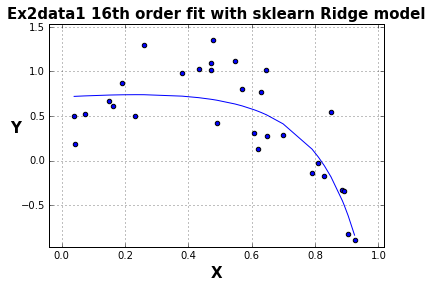

In [27]:
best = results[3]
print("RMSE: {}\nLambda: {}\nIntercept: {}\nParameters:\n\t{}".format(
        best[0],
        best[3],
        best[1],
        '\n\t'.join(best[2])))

data_plotter('Ex2data1 16th order fit with sklearn Ridge model')
Y_hat = np.array(best[4].predict(X))
pairs = sorted(zip(data.iloc[:, 0], Y_hat))
plt.plot([p[0] for p in pairs], [p[1] for p in pairs]) 

## 1-7 Fit the data using 16th order polynomial regression model with scikit-learn Lasso model. You need to try at least 3 different L1 penalty (for example, λ = 0.1, 1, 10). Plot the data with the fitted line. Print optimized weights. Print Root Mean Squared Error (RMSE).

### Fit the first dataset to a 16th order polynomial L1 regularized model using scikit-learn 

In [28]:
results = []
lambdas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.25]
for l in lambdas:
    model = linear_model.Lasso(alpha=l, max_iter=1e9)
    
    model.fit(X_train, y_train)
    y_hat = model.predict(X_train)
    rmse_train = sqrt(np.mean(np.square(y_hat - y_train)))
    
    y_hat = model.predict(X_test)
    rmse_test = sqrt(np.mean(np.square(y_hat - y_test)))
    results.append(((rmse_train, rmse_test), model.intercept_[0], [str(c) for c in model.coef_], l, model))

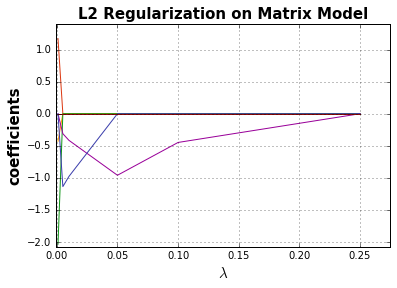

In [29]:
regularization_plotter('L2 Regularization on Matrix Model', results)

### Plot first dataset with the 16th order polynomial L1 regularized model fit to it

RMSE: (0.6906152595079509, 0.5998692003689615)
Lambda: 0.01
Intercept: 0.7414062427048025
Parameters:
	0.0
	0.0
	-0.0
	-0.0
	-0.415128072467
	-0.978842308996
	-0.0
	-0.0
	-0.0
	-0.0
	-0.0
	-0.0
	-0.0
	-0.0
	-0.0
	-0.0
	-0.0


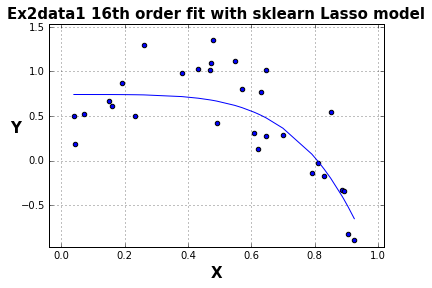

In [30]:
best = results[2]
print("RMSE: {}\nLambda: {}\nIntercept: {}\nParameters:\n\t{}".format(
        best[0],
        best[3],
        best[1],
        '\n\t'.join(best[2])))

data_plotter('Ex2data1 16th order fit with sklearn Lasso model')
Y_hat = np.array(best[4].predict(X))
pairs = sorted(zip(data.iloc[:, 0], Y_hat))
plt.plot([p[0] for p in pairs], [p[1] for p in pairs]) 

# 2 (30pts) Polynomial regression with train/validation/test

### Read in second dataset; remove outliers

In [31]:
data = pd.read_csv('ex2data2.csv')
#data = data[(data - data.mean()).abs()<=(8*data.std())].dropna() # remove 7 outliers
data = data[(data - data.mean()).abs()<=(7*data.std())].dropna() # remove 10 outliers
#data = data[(data - data.mean()).abs()<=(6*data.std())].dropna() # remove 21 outliers

### Redefine plotting function to conform with the second dataset

In [32]:
def data_plotter(title):
    formatting = {'fontsize': 15, 'weight': 'bold'}
    plt.title(title, formatting)
    plt.xlabel('Square feet', formatting)
    plt.ylabel('Price', formatting)
    plt.xlim(min(data.iloc[:, 0]) - (2 * min(data.iloc[:, 0])), 
             max(data.iloc[:, 0]) + (.1 * max(data.iloc[:, 0])))
    plt.ylim(min(data.iloc[:, -1]) - (2 * min(data.iloc[:, 0])), 
             max(data.iloc[:, -1]) + (.2 * max(data.iloc[:, 0])))
    plt.grid(True)
    plt.scatter(data.iloc[:, 0], data.iloc[:, -1])

## 2-1 Fit the data using linear (1st order) regression model (matrix form, gradient descent method). Plot the training data with the fitted line. Using the optimized weights, please calculated Root Mean Squared Error (RMSE) of training and testing data.

### Initialize learning rates, data,  labels, and weights

In [33]:
X = np.stack([
        np.ones((len(data))),
        scale(data.iloc[:, 0])],
        axis=1)
y = np.asmatrix(data.iloc[:, -1]).reshape(len(data), -1)

W_init = np.asmatrix(np.array([0., 0.]).reshape(2, 1))
W = np.copy(W_init)

### Create 80/20 training, testing split on the data and labels

In [34]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

### Perform matrix form gradient descent on the first dataset to fit a 1st order linear model

In [35]:
""" Train/test RMSE by number of outliers removed
0 outliers: 213397.77292948627, 118313.40253443283
7 outliers: 186363.08834748715, 119046.79191286175
10 outliers: 196675.61911150446, 97319.69256918874
21 outliers: 179688.83058578987, 102819.16176876823
"""

learning_rates = [0.1, 0.05, 0.01]
results = train_model(X_train, y_train, learning_rates, test_split=(X_test, y_test))


Training RMSE: 583847.4335480131
Testing RMSE: 273888.59987694083
Performing gradient descent with a learning rate of 0.1

Training RMSE: 226351.9571807877
Testing RMSE: 98394.85640605977
achieved after 0.83 seconds and 9844 iterations

Performing gradient descent with a learning rate of 0.05

Training RMSE: 226351.957181095
Testing RMSE: 98394.85640524636
achieved after 1.70 seconds and 18885 iterations

Performing gradient descent with a learning rate of 0.01
	Cost: 51235208527.035416

Training RMSE: 226351.9571839868
Testing RMSE: 98394.85639759398
achieved after 10.67 seconds and 86602 iterations

The best model has:
	RMSE = (226351.9571839868, 98394.85639759398)
	learning rate = 0.01
	W = 93178.731786921
	    2227815.5140132764


### Plot second dataset with the 1st order model fit to it 

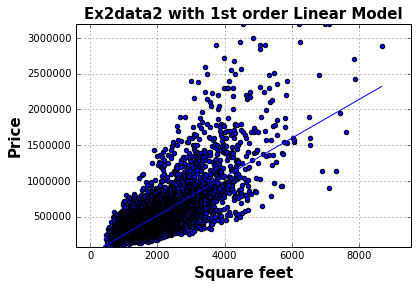

In [36]:
data_plotter('Ex2data2 with 1st order Linear Model')
W0, W1 = [float(w) for w in min(results)[-1]]
model = lambda x: W0 + W1*x
model_plotter(model)

## 2-2 Fit the data using 2nd order polynomial regression model (matrix form, gradient descent method). Plot the training data with the fitted line. Using the optimized weights, please calculated Root Mean Squared Error (RMSE) of training and testing data. Note: Do not forget feature normalization.

### Initialize learning rates, data,  labels, and weights

In [37]:
X = np.stack([
        np.ones((len(data))),
        scale(data.iloc[:, 0]),
        scale(list(map(lambda x: x**2, data.iloc[:, 0])))],
        axis=1)
y = np.asmatrix(data.iloc[:, -1]).reshape(len(data), -1)

W_init = np.asmatrix(np.array([0., 0., 0.]).reshape(3, 1))
W = np.copy(W_init)

### Create 80/20 training, testing split on the data and labels

In [38]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

### Perform matrix form gradient descent on the first dataset to fit a 2nd order linear model

In [39]:
learning_rates = [1, 0.75, 0.5]
results = train_model(X_train, y_train, learning_rates, test_split=(X_test, y_test))


Training RMSE: 583847.4335480131
Testing RMSE: 273888.59987694083
Performing gradient descent with a learning rate of 1

Training RMSE: 613927.8493155284
Testing RMSE: 303261.5412471604
achieved after 0.00 seconds and 1 iterations

Performing gradient descent with a learning rate of 0.75

Training RMSE: 221514.52105521248
Testing RMSE: 97615.04991794919
achieved after 4.05 seconds and 32615 iterations

Performing gradient descent with a learning rate of 0.5

Training RMSE: 221514.52105603108
Testing RMSE: 97615.04991207209
achieved after 5.90 seconds and 47464 iterations

The best model has:
	RMSE = (221514.52105603108, 97615.04991207209)
	learning rate = 0.5
	W = 204490.01488197251
	    969490.1234438105
	    2106628.408283753


### Plot second dataset with the 2nd order model fit to it

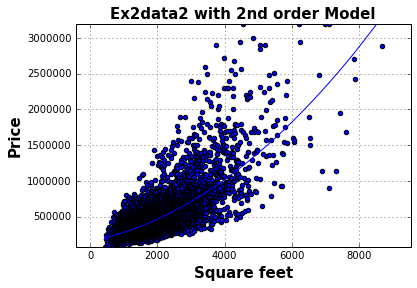

In [40]:
data_plotter('Ex2data2 with 2nd order Model')
W0, W1, W2 = [float(w) for w in min(results)[-1]]
model = lambda x: W0 + W1*x + W2*x**2
model_plotter(model)

## 2-3 Fit the data using 4th order polynomial regression model (matrix form, gradient descent method). Plot the training data with the fitted line. Using the optimized weights, please calculated Root Mean Squared Error (RMSE) of training and testing data. Note: Do not forget feature normalization.

### Initialize learning rates, data,  labels, and weights

In [41]:
X = np.stack([
        np.ones((len(data))),
        scale(data.iloc[:, 0]),
        scale(list(map(lambda x: x**2, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**3, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**4, data.iloc[:, 0])))],
        axis=1)
y = np.asmatrix(data.iloc[:, -1]).reshape(len(data), -1)

W_init = np.asmatrix(np.array([0., 0., 0., 0., 0.]).reshape(5, 1))
W = np.copy(W_init)

### Create 80/20 training, testing split on the data and labels

In [42]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

### Perform matrix form gradient descent on the first dataset to fit a 4th order linear model

In [43]:
learning_rates = [1, 0.8, 0.6]
results = train_model(X_train, y_train, learning_rates, test_split=(X_test, y_test))


Training RMSE: 583847.4335480131
Testing RMSE: 273888.59987694083
Performing gradient descent with a learning rate of 1

Training RMSE: 614219.7513908428
Testing RMSE: 303513.0934332098
achieved after 0.00 seconds and 1 iterations

Performing gradient descent with a learning rate of 0.8

Training RMSE: 221003.05214353307
Testing RMSE: 98615.75890600028
achieved after 4.42 seconds and 26679 iterations

Performing gradient descent with a learning rate of 0.6

Training RMSE: 221003.05214367292
Testing RMSE: 98615.7629783865
achieved after 6.12 seconds and 35573 iterations

The best model has:
	RMSE = (221003.05214353307, 98615.75890600028)
	learning rate = 0.8
	W = 225413.7375858839
	    631677.2096439624
	    2786009.7044863612
	    660805.6090245253
	    -1463271.7835384912


### Plot second dataset with the 4th order model fit to it

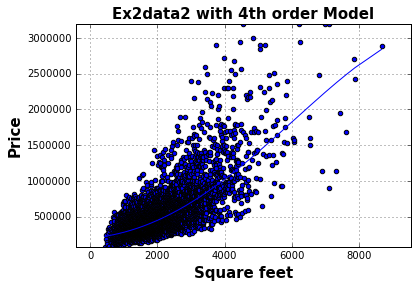

In [44]:
data_plotter('Ex2data2 with 4th order Model')
W0, W1, W2, W3, W4 = [float(w) for w in min(results)[-1]]
model = lambda x: W0 + W1*x + W2*x**2 + W3*x**3 + W4*x**4
model_plotter(model)

## 2-4 Fit the data using 16th order polynomial regression model (matrix form, gradient descent method). Plot the training data with the fitted line. Using the optimized weights, please calculated Root Mean Squared Error (RMSE) of training and testing data. Note: Do not forget feature normalization.

### Initialize learning rates, data,  labels, and weights

In [45]:
X = np.stack([
        np.ones((len(data))),
        scale(data.iloc[:, 0]),
        scale(list(map(lambda x: x**2, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**3, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**4, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**5, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**6, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**7, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**8, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**9, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**10, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**11, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**12, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**13, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**14, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**15, data.iloc[:, 0]))),
        scale(list(map(lambda x: x**16, data.iloc[:, 0])))],
        axis=1)
y = np.asmatrix(data.iloc[:, -1]).reshape(len(data), -1)

W_init = np.asmatrix(np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]).reshape(-1, 1))
W = np.copy(W_init)

### Create 80/20 training, testing split on the data and labels

In [46]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

### Perform matrix form gradient descent on the first dataset to fit a 16th order linear model

In [47]:
learning_rates = [1, 0.85, 0.7]
results = train_model(X_train, y_train, learning_rates, test_split=(X_test, y_test))


Training RMSE: 583847.4335480131
Testing RMSE: 273888.59987694083
Performing gradient descent with a learning rate of 1

Training RMSE: 614161.8493110256
Testing RMSE: 303514.1023660082
achieved after 0.00 seconds and 1 iterations

Performing gradient descent with a learning rate of 0.85
	Cost: 48474353154.26005

Training RMSE: 220163.91183028746
Testing RMSE: 98441.11545736015
achieved after 13.37 seconds and 17790 iterations

Performing gradient descent with a learning rate of 0.7
	Cost: 48478967773.91695

Training RMSE: 220163.91183038158
Testing RMSE: 98441.1065280627
achieved after 15.90 seconds and 21602 iterations

The best model has:
	RMSE = (220163.91183038158, 98441.1065280627)
	learning rate = 0.7
	W = 236405.4757470775
	    603743.8180672303
	    2388730.072747756
	    1236661.239160493
	    23072.034703169807
	    -616755.0403604655
	    -811687.9597191011
	    -763784.7972922252
	    -607874.9531432842
	    -416931.1606875259
	    -226256.07108083362
	    -51079.06889588

### Plot second dataset with the 16th order model fit to it

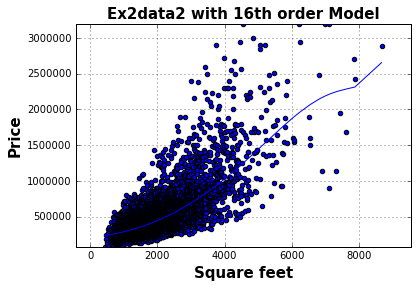

In [48]:
data_plotter('Ex2data2 with 16th order Model')
W0, W1, W2, W3, W4, W5, W6, W7, W8, W9, W10, W11, W12, W13, W14, W15, W16 = [float(w) for w in min(results)[-1]]
model = lambda x: W0 + W1*x + W2*x**2 + W3*x**3 + W4*x**4 + W5*x**5 + W6*x**6 + W7*x**7 + W8*x**8 + W9*x**9 \
                + W10*x**10 + W11*x**11 + W12*x**12 + W13*x**13 + W14*x**14 + W15*x**15 + W16*x**16
model_plotter(model)

## 2-5 Fit the data using 16th order polynomial regression model with ridge (L2 penalty) regularization. You need to try at least 3 different L2 penalty (for example, λ = 0.1, 1, 10). Plot the training and validation data with the fitted line. Search optimum L2 penalty based on Root Mean Squared Error (RMSE) of validation data. Print optimized weight coefficients. Plot weight coefficients with L2 penalty. Print Root Mean Squared Error (RMSE) for training/validation/test data. Note: Do not forget feature normalization.

### Create 60/20/20 training, validation, testing split on the data and labels

In [49]:
X_, X_test, y_, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_, y_, test_size=0.25, random_state=1)

### Redefine cost and cost derivative functions to include the L2 regularization term; initialize lambda values

In [50]:
J = lambda X, y: (1/len(data)) * (np.dot((np.dot(X, W) - y).T, np.dot(X, W) - y) \
        + np.multiply(l, np.dot(W.T, W)))
dJ_dW = lambda X, y: (2/len(data)) * (np.dot(np.dot(X.T, X), W) - np.dot(X.T, y) \
        + np.multiply(l, np.dot(np.eye(W.shape[0]), W)))
lambdas = [0.1, 1, 5, 10, 50, 100, 200, 300, 500]

### Tune model on validation set to find optimal lambda for L2 regularization

In [51]:
learning_rate = min(results, key=lambda x: x[0][1])[1]
results = []
for l in lambdas:
    print('Performing gradient descent with an L2 regularization parameter of {}'.format(l))
    W = np.copy(W_init)
    results.append(train_model(X_val, y_val, [learning_rate], suppress_results=True, test_split=(X_test, y_test))[0] + [l])

Performing gradient descent with an L2 regularization parameter of 0.1

Training RMSE: 107350.87110534022
Testing RMSE: 96782.26120664935
achieved after 4.44 seconds and 6085 iterations

Performing gradient descent with an L2 regularization parameter of 1

Training RMSE: 110750.02053726198
Testing RMSE: 99724.1084995806
achieved after 0.83 seconds and 1258 iterations

Performing gradient descent with an L2 regularization parameter of 5

Training RMSE: 120528.41583277556
Testing RMSE: 107872.0477661509
achieved after 0.06 seconds and 97 iterations

Performing gradient descent with an L2 regularization parameter of 10

Training RMSE: 128884.13015601978
Testing RMSE: 113876.52749983709
achieved after 0.04 seconds and 56 iterations

Performing gradient descent with an L2 regularization parameter of 50

Training RMSE: 154038.52901401607
Testing RMSE: 135204.03977859693
achieved after 0.01 seconds and 16 iterations

Performing gradient descent with an L2 regularization parameter of 100

Trai

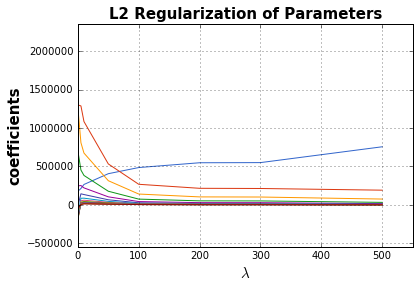

In [52]:
regularization_plotter('L2 Regularization of Parameters', results)
#lambdas = [0.1, 1, 5, 10, 50, 100, 200, 300, 500]

### Plot second dataset with the 16th order L2 regularized model fit to it

Training RMSE: 154038.52901401607
Testing RMSE: 135204.03977859693
Lambda: 50
Parameters:
	[ 405871.32515425]
	[ 532749.42117982]
	[ 314690.94952317]
	[ 177665.99848219]
	[ 104915.1398367]
	[ 66622.75512007]
	[ 45650.20976233]
	[ 33518.61011141]
	[ 26085.87827014]
	[ 21274.5393593]
	[ 18000.59932483]
	[ 15673.16611551]
	[ 13955.6003043]
	[ 12647.72023499]
	[ 11625.55198445]
	[ 10809.34679579]
	[ 10145.97483398]


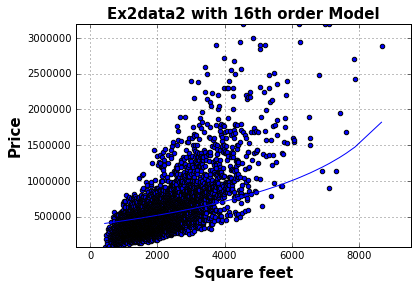

In [53]:
best = results[4]
print("Training RMSE: {}\nTesting RMSE: {}\nLambda: {}\nParameters:\n\t{}".format(
        best[0][0],
        best[0][1],
        best[3],
        '\n\t'.join([str(w) for w in best[2]])))

data_plotter('Ex2data2 with 16th order Model')
W0, W1, W2, W3, W4, W5, W6, W7, W8, W9, W10, W11, W12, W13, W14, W15, W16 = [float(w) for w in best[2]]
model = lambda x: W0 + W1*x + W2*x**2 + W3*x**3 + W4*x**4 + W5*x**5 + W6*x**6 + W7*x**7 + W8*x**8 + W9*x**9 \
                + W10*x**10 + W11*x**11 + W12*x**12 + W13*x**13 + W14*x**14 + W15*x**15 + W16*x**16
model_plotter(model)

## 2-6 Fit the data using 16th order polynomial regression model with scikit-learn Ridge model. You need to try at least 3 different L2 penalty (for example, λ = 0.1, 1, 10). Plot the data with the fitted line. Print optimized weights. Plot weight coefficients with L2 penalty. Print Root Mean Squared Error (RMSE).

### Fit the second dataset to a 16th order polynomial L2 regularized model using scikit-learn 

In [54]:
results = []
for l in lambdas:
    print('Performing gradient descent with an L2 regularization parameter of {}'.format(l))
    
    model = linear_model.Ridge(alpha=l)
    
    model.fit(X_train, y_train)
    y_hat = model.predict(X_train)
    rmse_train = sqrt(np.mean(np.square(y_hat - y_train)))
    
    y_hat = model.predict(X_test)
    rmse_test = sqrt(np.mean(np.square(y_hat - y_test)))
    results.append(((rmse_train, rmse_test), model.intercept_[0], [str(c) for c in model.coef_[0]], l, model))

Performing gradient descent with an L2 regularization parameter of 0.1
Performing gradient descent with an L2 regularization parameter of 1
Performing gradient descent with an L2 regularization parameter of 5
Performing gradient descent with an L2 regularization parameter of 10
Performing gradient descent with an L2 regularization parameter of 50
Performing gradient descent with an L2 regularization parameter of 100
Performing gradient descent with an L2 regularization parameter of 200
Performing gradient descent with an L2 regularization parameter of 300
Performing gradient descent with an L2 regularization parameter of 500


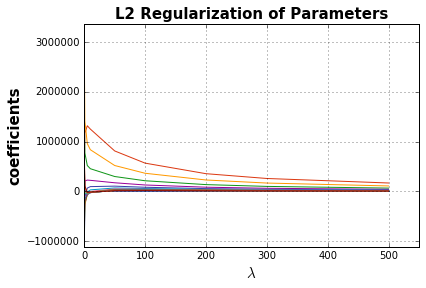

In [55]:
regularization_plotter('L2 Regularization of Parameters', results)
#lambdas = [0.1, 1, 5, 10, 50, 100, 200, 300, 500]


### Plot second dataset with the 16th order polynomial L2 regularized model (sklearn Ridge) fit to it

Training RMSE: 274321.4544353513
Testing RMSE: 228529.2576436946
Lambda: 50
Intercept: 332932.7015215546
Parameters:
	0.0
	811382.082694
	518364.418967
	297120.147297
	171465.179323
	103902.232223
	67120.6953827
	46391.4629728
	34209.0636515
	26730.8560247
	21938.9559993
	18738.8526374
	16516.3801057
	14915.2608587
	13722.1708301
	12805.5122463
	12081.792148


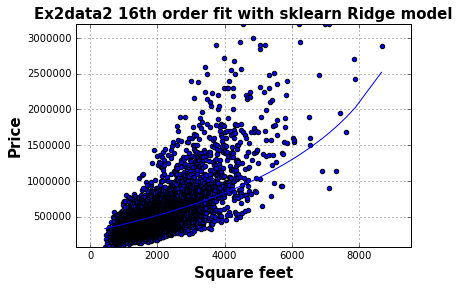

In [56]:
best = results[4]
print("Training RMSE: {}\nTesting RMSE: {}\nLambda: {}\nIntercept: {}\nParameters:\n\t{}".format(
        best[0][0],
        best[0][1],
        best[3],
        best[1],
        '\n\t'.join(best[2])))

data_plotter('Ex2data2 16th order fit with sklearn Ridge model')
Y_hat = np.array(best[4].predict(X))
pairs = sorted(zip(data.iloc[:, 0], Y_hat))
plt.plot([p[0] for p in pairs], [p[1] for p in pairs]) 

## 2-7 Fit the data using 16th order polynomial regression model with scikit-learn Lasso model. You need to try at least 3 different L1 penalty (for example, λ = 0.1, 1, 10). Plot the data with the fitted line. Print optimized weights. Plot weight coefficients with L2 penalty. Print Root Mean Squared Error (RMSE).

### Fit the second dataset to a 16th order polynomial L1 regularized model using scikit-learn 

In [57]:
results = []
for l in lambdas:
    print('Performing gradient descent with an L2 regularization parameter of {}'.format(l))

    model = linear_model.Lasso(alpha=l, tol=1, max_iter=1e5)

    model.fit(X_train, y_train)
    y_hat = model.predict(X_train)
    rmse_train = sqrt(np.mean(np.square(y_hat - y_train)))
    
    y_hat = model.predict(X_test)
    rmse_test = sqrt(np.mean(np.square(y_hat - y_test)))
    results.append(((rmse_train, rmse_test), model.intercept_[0], [str(c) for c in model.coef_], l, model))

Performing gradient descent with an L2 regularization parameter of 0.1
Performing gradient descent with an L2 regularization parameter of 1
Performing gradient descent with an L2 regularization parameter of 5
Performing gradient descent with an L2 regularization parameter of 10
Performing gradient descent with an L2 regularization parameter of 50
Performing gradient descent with an L2 regularization parameter of 100
Performing gradient descent with an L2 regularization parameter of 200
Performing gradient descent with an L2 regularization parameter of 300
Performing gradient descent with an L2 regularization parameter of 500


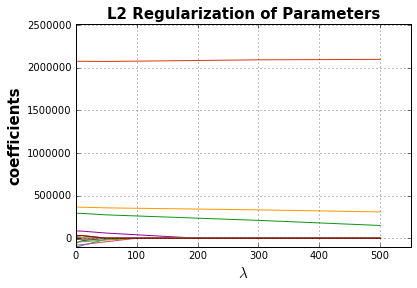

In [58]:
regularization_plotter('L2 Regularization of Parameters', results)
#lambdas = [0.1, 1, 5, 10, 50, 100, 200, 300, 500]

### Plot second dataset with the 16th order polynomial L1 regularized model fit to it

Training RMSE: 453146.1790899245
Testing RMSE: 415832.4449261249
Lambda: 50
Intercept: 92540.50728051492
Parameters:
	0.0
	2073706.63318
	356080.812274
	274114.010073
	60358.5150194
	-0.0
	-11108.2185091
	-41410.6784003
	-20689.2389953
	-3506.36609521
	-0.0
	-0.0
	-0.0
	-0.0
	-0.0
	-0.0
	-0.0


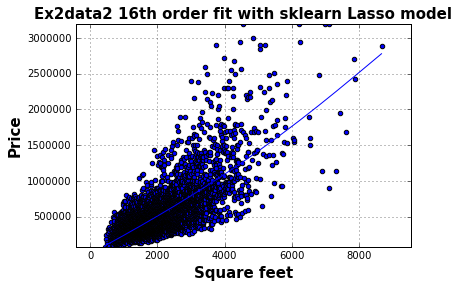

In [59]:
best = results[4]
print("Training RMSE: {}\nTesting RMSE: {}\nLambda: {}\nIntercept: {}\nParameters:\n\t{}".format(
        best[0][0],
        best[0][1],
        best[3],
        best[1],
        '\n\t'.join(best[2])))

data_plotter('Ex2data2 16th order fit with sklearn Lasso model')
Y_hat = np.array(best[4].predict(X))
pairs = sorted(zip(data.iloc[:, 0], Y_hat))
plt.plot([p[0] for p in pairs], [p[1] for p in pairs])

# 3 (40pts) Regularization with Tensorflow

### Read in third dataset; remove outliers

In [60]:
data = pd.read_csv('ex2data3.csv')
df = data[(data - data.mean()).abs()<=(10*data.std())].dropna() # remove 43 outliers

## 3-1 Fit the training data using regression model with ridge (L2 penalty) regularization with scikit-learn Ridge model. You need to try at least 3 different L2 penalty (for example, λ = 0.1, 1, 10). Search optimum L2 penalty based on Root Mean Squared Error (RMSE) of validation data. Print optimized weight coefficients. Plot weight coefficients with L2 penalty. Print Root Mean Squared Error (RMSE) for training/validation/test data. Note: Do not forget feature normalization

### Initialize learning rates, data,  labels, and weights

In [61]:
X = np.stack([
        np.ones((len(data))),
        scale(data.iloc[:, 0]),
        scale(data.iloc[:, 1]),
        scale(data.iloc[:, 2]),
        scale(data.iloc[:, 3]),
        scale(data.iloc[:, 4]),
        scale(data.iloc[:, 5]),
        scale(data.iloc[:, 6]),
        scale(data.iloc[:, 7]),
        scale(data.iloc[:, 8]),
        scale(data.iloc[:, 9])],
        axis=1)
y = np.asmatrix(data.iloc[:, -1]).reshape(len(data), -1)

### Create 80/20 training, testing split on the data and labels

In [62]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

### Fit the second dataset to a 16th order polynomial L2 regularized model using scikit-learn 

In [63]:
results = []
lambdas = [0.1, 1, 5, 10, 50, 100]
for l in lambdas:
    print('Performing gradient descent with an L2 regularization parameter of {}'.format(l))
    
    model = linear_model.Ridge(alpha=l)
    
    model.fit(X_train, y_train)
    y_hat = model.predict(X_train)
    rmse_train = sqrt(np.mean(np.square(y_hat - y_train)))
    
    y_hat = model.predict(X_test)
    rmse_test = sqrt(np.mean(np.square(y_hat - y_test)))
    results.append(((rmse_train, rmse_test), model.intercept_[0], [str(c) for c in model.coef_[0]], l, model))

Performing gradient descent with an L2 regularization parameter of 0.1
Performing gradient descent with an L2 regularization parameter of 1
Performing gradient descent with an L2 regularization parameter of 5
Performing gradient descent with an L2 regularization parameter of 10
Performing gradient descent with an L2 regularization parameter of 50
Performing gradient descent with an L2 regularization parameter of 100


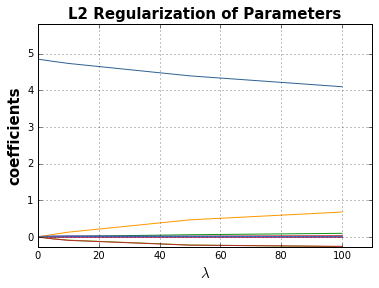

In [64]:
regularization_plotter('L2 Regularization of Parameters', results)
#lambdas = [0.1, 1, 5, 10, 50, 100]


### Print the 16th order polynomial L2 regularized model (sklearn Ridge) fit to the second dataset

In [65]:
best = results[4]
print("Training RMSE: {}\nTesting RMSE: {}\nLambda: {}\nIntercept: {}\nParameters:\n\t{}".format(
        best[0][0],
        best[0][1],
        best[3],
        best[1],
        '\n\t'.join(best[2]))) 

Training RMSE: 0.07147524135390729
Testing RMSE: 0.07106425321194611
Lambda: 50
Intercept: 0.3584351707033038
Parameters:
	0.0
	0.0178053381357
	0.466969119508
	0.0608398669162
	0.0159110759806
	0.0188140632554
	0.00302167117898
	-0.0112549556504
	-0.21874219695
	-0.224002930877
	4.39293428519


## 3-2 Fit the training data using regression model with lasso (L1 penalty) regularization with scikit-learn Lasso model. You need to try at least 3 different L1 penalty (for example, λ = 0.1, 1, 10). Search optimum L1 penalty based on Root Mean Squared Error (RMSE) of validation data. Print optimized weight coefficients. Plot weight coefficients with L2 penalty. Print Root Mean Squared Error (RMSE) for training/validation/test data. Note: Do not forget feature normalization

### Fit the third dataset to a 16th order polynomial L1 regularized model using scikit-learn 

In [66]:
results = []
lambdas = [0.001, 0.005, 0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
for l in lambdas:
    print('Performing gradient descent with an L2 regularization parameter of {}'.format(l))

    model = linear_model.Lasso(alpha=l, max_iter=1e5)

    model.fit(X_train, y_train)
    y_hat = model.predict(X_train)
    rmse_train = sqrt(np.mean(np.square(y_hat - y_train)))
    
    y_hat = model.predict(X_test)
    rmse_test = sqrt(np.mean(np.square(y_hat - y_test)))
    results.append(((rmse_train, rmse_test), model.intercept_[0], [str(c) for c in model.coef_], l, model))

Performing gradient descent with an L2 regularization parameter of 0.001
Performing gradient descent with an L2 regularization parameter of 0.005
Performing gradient descent with an L2 regularization parameter of 0.01
Performing gradient descent with an L2 regularization parameter of 0.03
Performing gradient descent with an L2 regularization parameter of 0.05
Performing gradient descent with an L2 regularization parameter of 0.07
Performing gradient descent with an L2 regularization parameter of 0.09
Performing gradient descent with an L2 regularization parameter of 0.1
Performing gradient descent with an L2 regularization parameter of 0.2
Performing gradient descent with an L2 regularization parameter of 0.3
Performing gradient descent with an L2 regularization parameter of 0.4
Performing gradient descent with an L2 regularization parameter of 0.5


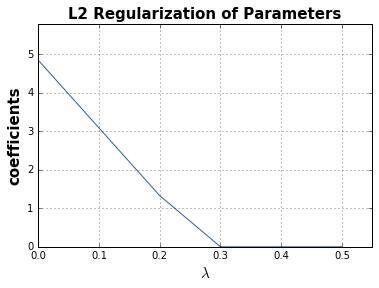

In [67]:
regularization_plotter('L2 Regularization of Parameters', results)
#lambdas = [0.001, 0.005, 0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]

### Print the 16th order polynomial L1 regularized (sklearn Lasso) model fit to the second dataset

In [68]:
best = results[3]
print("Training RMSE: {}\nTesting RMSE: {}\nLambda: {}\nIntercept: {}\nParameters:\n\t{}".format(
        best[0][0],
        best[0][1],
        best[3],
        best[1],
        '\n\t'.join(best[2])))

Training RMSE: 1.54825729559288
Testing RMSE: 1.5340406184312905
Lambda: 0.03
Intercept: 0.3598740817402466
Parameters:
	0.0
	0.0
	0.0
	0.0
	0.0
	-0.0
	-0.0
	-0.0
	-0.0
	-0.0
	4.32186664252


## 3-3 Fit the training data using regression model with ridge (L2 penalty) regularization using TensorFlow. You need to make gradient descent method instead of open source algorithm. You need to try at least 3 different L2 penalty (for example, λ = 0.1, 1, 10). Search optimum L2 penalty based on Root Mean Squared Error (RMSE) of validation data. Print optimized weight coefficients. Plot weight coefficients with L2 penalty. Print Root Mean Squared Error (RMSE) for training/validation/test data. Note: Do not forget feature normalization.

In [69]:
W = tf.Variable(tf.zeros([X_train.shape[1], 1]), name='weights')
b = tf.Variable(tf.zeros([1, X_train.shape[1]]), name='bias')

X = tf.placeholder(tf.float32, name='X')
Y = tf.placeholder(tf.float32, name='Y')

Y_predicted = b + tf.matmul(X, W)

loss = tf.reduce_mean(tf.square(Y_predicted - Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)
epochs = 10

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(epochs):
        for x, y in zip(X_train, y_train):
            sess.run(optimizer, feed_dict={X: x, Y: y})
            
        c = sess.run(loss, feed_dict={X: X_train, Y: y_train})
        print('Epoch: {:03d}    cost= {:.9f}'.format(i+1, c))
            
    w_val, b_val = sess.run([W, b])
    rmse = sess.run(tf.sqrt(loss), feed_dict={X: X_train, Y: y_train})
    
print("RMSE: {}\nW: {}\nb: {}".format(rmse, w_val, b_val))

InvalidArgumentError: In[0] is not a matrix
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_X_0_0, weights/read)]]

Caused by op 'MatMul', defined at:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.4/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.4/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-69-85961aec241c>", line 7, in <module>
    Y_predicted = b + tf.matmul(X, W)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/math_ops.py", line 1816, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 1217, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): In[0] is not a matrix
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_X_0_0, weights/read)]]
